In [1]:
%load_ext autoreload

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
from toi5671 import read_all_phot, colors, np, pl

/home/jp/miniconda3/envs/toi5671/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
lcs = read_all_phot(phot_dir='../data/photometry')
del lcs['TESS'] 
lcs.keys()

dict_keys(['gp', 'V', 'rp', 'ip', 'zs'])

In [5]:
pwd

'/home/jp/github/research/project/toi5671/notebooks'

In [6]:
nbands = len(lcs)
nbands

5

In [7]:
nlcs = sum([len(v) for k,v in lcs.items()])
nlcs

8

In [8]:
period = 3.3079817 #± 0.0006559
t0 = 2459685.753346 #± 0.0018235 

In [9]:
def get_epoch_tc(times, period, t0):
    n = int(np.floor((max(times)-t0)/period))
    return t0+n*period

t = lcs['V']['lco1m'].BJD_TDB.values
tc = get_epoch_tc(t, period, t0)
t-tc

array([-9.46656992e-02, -8.97036628e-02, -8.47066259e-02, -7.97465895e-02,
       -7.47555541e-02, -6.97945175e-02, -6.48264815e-02, -5.98194436e-02,
       -5.48514072e-02, -4.98893713e-02, -4.49163350e-02, -3.99512998e-02,
       -3.49552627e-02, -2.48811906e-02, -1.99181540e-02, -1.49011174e-02,
       -9.93608125e-03, -4.97404533e-03,  3.59904952e-05,  5.00202645e-03,
        9.99506237e-03,  1.49740987e-02,  1.99521328e-02,  2.49191690e-02,
        2.99072061e-02,  3.48682418e-02,  3.98282763e-02,  4.47883122e-02,
        4.97663482e-02,  5.47343832e-02])

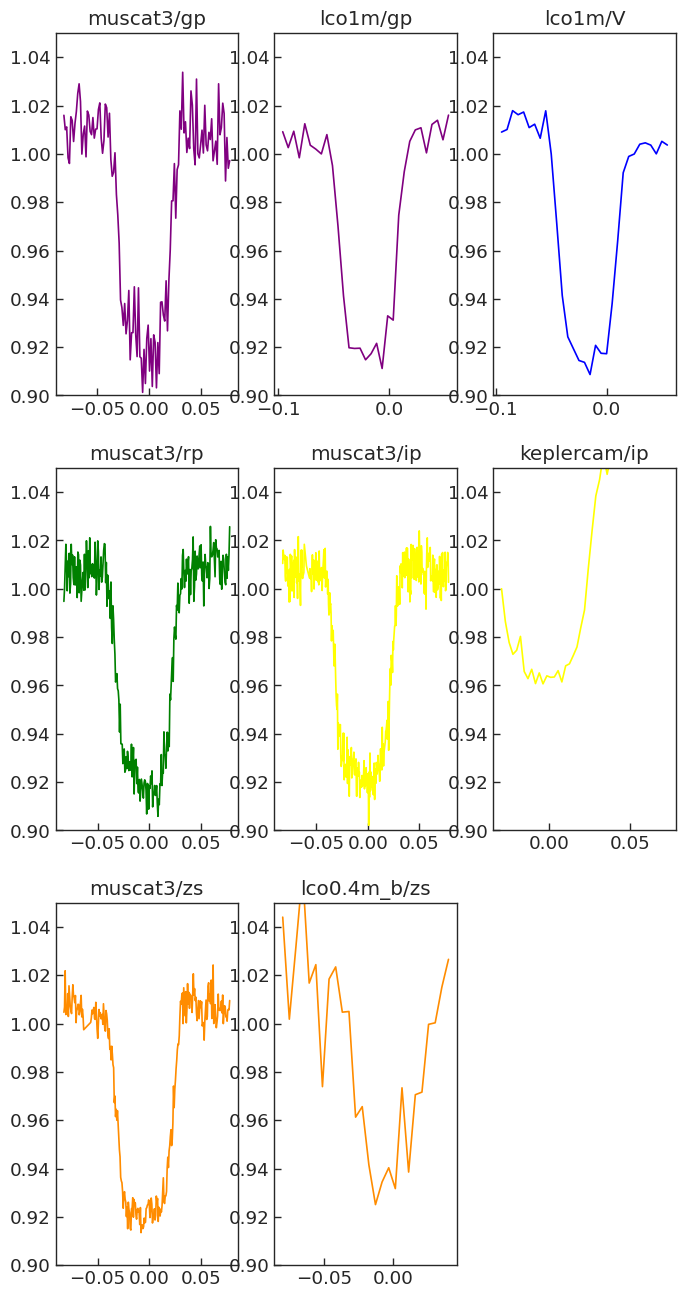

In [10]:
fig = pl.figure(figsize=(8,16))
i = 0
for band,dfs in lcs.items():
    for inst,df in dfs.items():
        ax = fig.add_subplot(nlcs//3+1,3,1+i)

        t = df.BJD_TDB
        f = df.Flux/np.median(df.Flux)
        tc = get_epoch_tc(t, period, t0)
        ax.plot(t-tc, f, color=colors[band])
        ax.set_title(f'{inst}/{band}')
        i+=1
        ax.set_ylim(0.9, 1.05)
# fig.tight_layout()

In [11]:
from toi5671 import Star, Planet

target_name = 'TOI-5671'
star = Star(target_name)
star_params = star.params_to_dict()
star_params

Mstar=(0.40,0.02) Msun
Rstar=(0.41,0.01) Rsun
Rhostar=(5.89,0.62) rhosun
teff=(3380,157) K
logg=(4.82,0.00) cgs
feh=(0.00,0.10) dex


{'rstar': (0.408427, 0.0125522),
 'mstar': (0.408427, 0.0125522),
 'rhostar': (5.885181788660491, 0.620913145319562),
 'teff': (3380.0, 157.0),
 'logg': (4.81894, 0.00440884),
 'feh': (0.0, 0.1)}

In [12]:
planet = Planet(target_name, star_params=star_params, alias='.01', source='toi')
planet_params = planet.params_to_dict()
planet_params

t0=(2459685.753346, 0.0018235) BJD
P=(3.3079817, 0.0006559) d
Rp/Rs=[0.28492104 0.01190273]


{'t0': (2459685.753346, 0.0018235),
 'period': (3.3079817, 0.0006559),
 'tdur': array([0.        , 0.00758333]),
 'imp': (0.0, 0.1),
 'rprs': array([0.28492104, 0.01190273]),
 'a_Rs': (16.86725928839332, 0.5931905699076486)}

In [13]:
#from joint M3 fit
planet_params['t0'] = (2459761.832417735, 6.361031306592546e-05)
planet_params['period'] =  (3.30783,0.0001)
planet_params['tdur'] = (0.0752, 0.0003)
planet_params['rprs'] = (0.27, 0.01)

In [14]:
from toi5671 import TransitFit

lcs = read_all_phot(phot_dir='../data/photometry')
del lcs['TESS']
lcs.keys()

dict_keys(['gp', 'V', 'rp', 'ip', 'zs'])

In [15]:
tf = TransitFit(name=target_name, 
                alias='b',
                star_params=star_params,
                planet_params=planet_params,
                data=lcs,
                use_r1r2=False,
                DEBUG=False
               )
tf.model_params

{'t0': (2459761.832417735, 6.361031306592546e-05),
 'period': (3.30783, 0.0001),
 'a_Rs': (16.86725928839332, 0.5931905699076486),
 'imp': (0.0, 0.1),
 'k': (0.27, 0.01),
 'd_gp_muscat3': (0.0, 0.0),
 'd_gp_lco1m': (0.0, 0.0),
 'd_V_lco1m': (0.0, 0.0),
 'd_rp_muscat3': (0.0, 0.0),
 'd_ip_muscat3': (0.0, 0.0),
 'd_ip_keplercam': (0.0, 0.0),
 'd_zs_muscat3': (0.0, 0.0),
 'd_zs_lco0.4m_b': (0.0, 0.0)}

In [16]:
tf.bands

['gp', 'V', 'rp', 'ip', 'zs']

In [17]:
tf.instruments

['muscat3', 'keplercam', 'lco1m', 'lco0.4m_b']

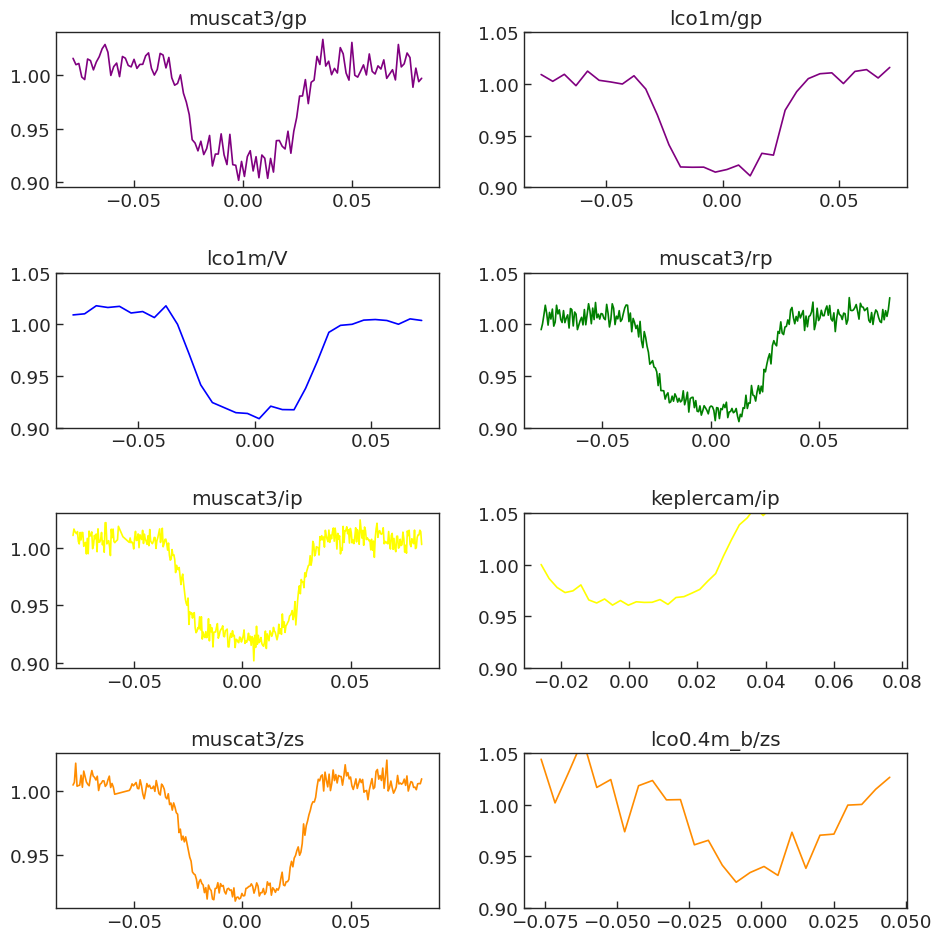

In [18]:
fig = tf.plot_raw_data()

In [19]:
tf.optimize_chi2_linear_baseline()

2728254.4298901227 True [-1.88970782e-11  9.23846088e-11  2.05531787e-11 -3.15493190e-11
 -3.18152395e-11  4.05249149e-11  2.24220403e-11  2.00633836e-11]


In [20]:
qc,qe = tf.ldtk_profiles.coeffs_qd()
for i,j in zip(qc,qe):
    print(f"q1={i[0]}")
    print(f"q2={i[1]}")

q1=0.5234636326168323
q2=0.28401266923747437
q1=0.5468552446629902
q2=0.26313249604808486
q1=0.516814813555506
q2=0.24980142489325424
q1=0.3149874845164077
q2=0.28547240690764575
q1=0.24375777771530152
q2=0.27447792647328656


In [21]:
pv = tf.pv_updated
tf.get_chi2_transit(pv)

24337439304.7748

In [22]:
pv = tf.pv_init
while True:
    tf.optimize_chi2_transit(pv)
    if tf.opt_result.success:
        break

Parameter        Init.     Opt.  %Diff
t0-2459761  :   0.8324  2.4862   -66.5
period      :   3.3078  3.3078     0.0
a_Rs        :  16.8673 17.6116    -4.2
imp         :   0.0000  0.0002  -100.0
k           :   0.2700  0.2700     0.0
d_gp_muscat3:   0.0000  0.0000  -100.0
d_gp_lco1m  :   0.0000  0.0001  -100.0
d_V_lco1m   :   0.0000  0.0003  -100.0
d_rp_muscat3:   0.0000 -0.0002  -100.0
d_ip_muscat3:   0.0000 -0.0002  -100.0
d_ip_keplercam:   0.0000  0.0000  -100.0
d_zs_muscat3:   0.0000 -0.0002  -100.0
d_zs_lco0.4m_b:   0.0000  0.0000  -100.0


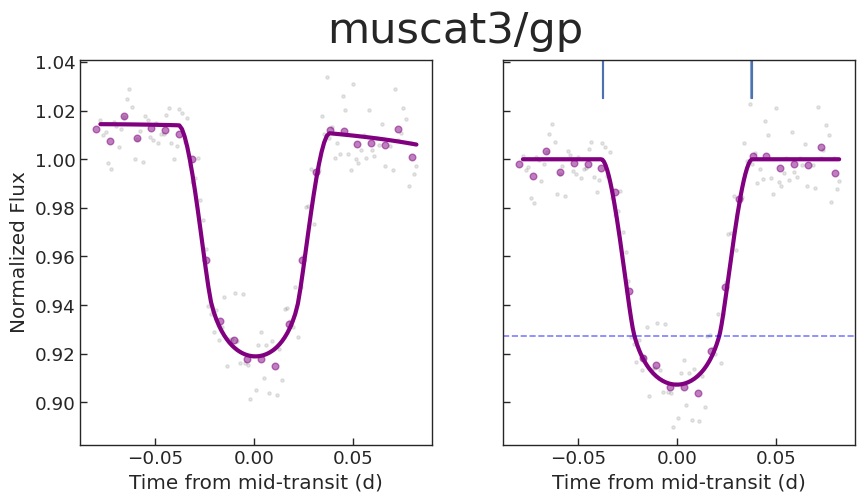

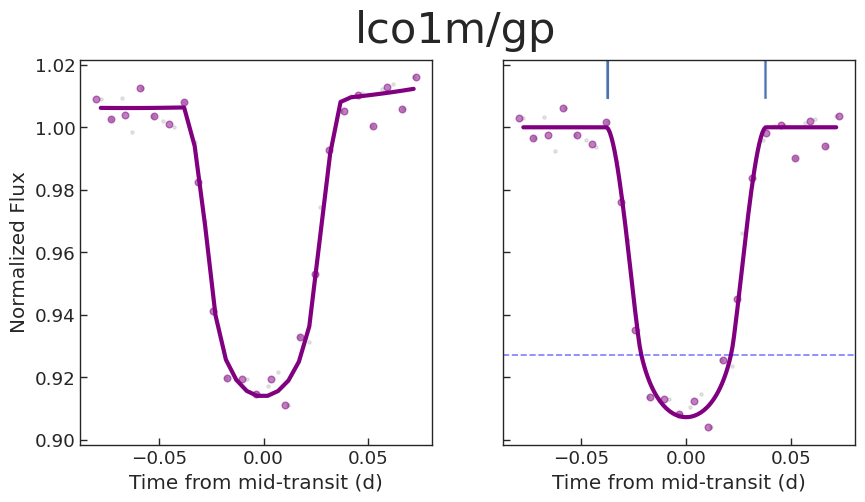

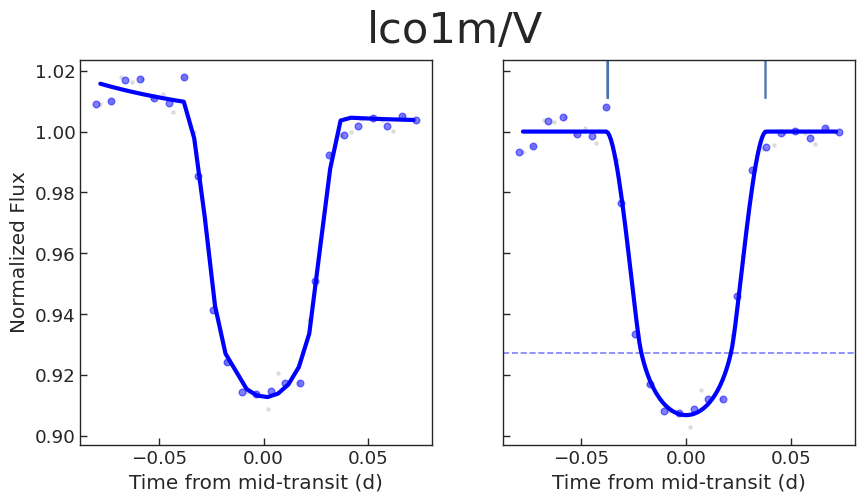

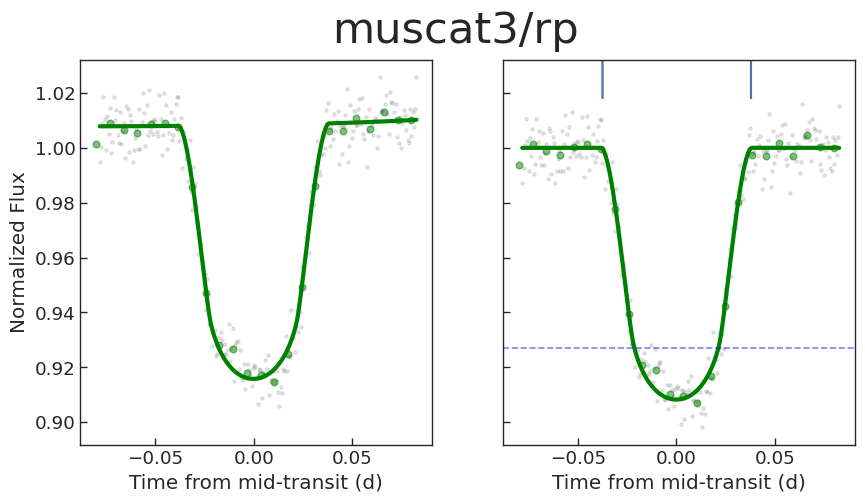

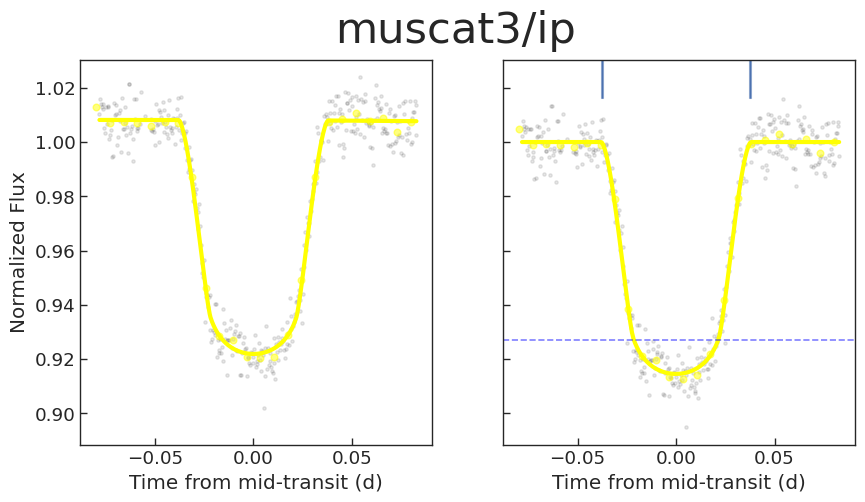

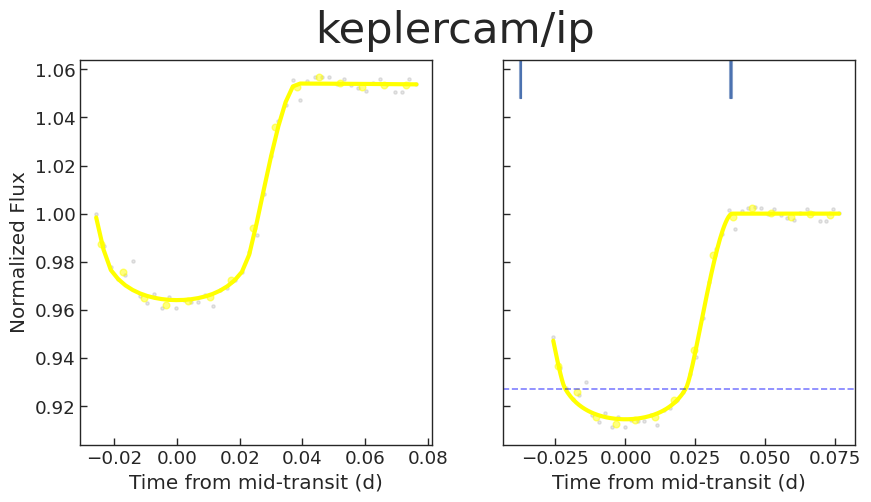

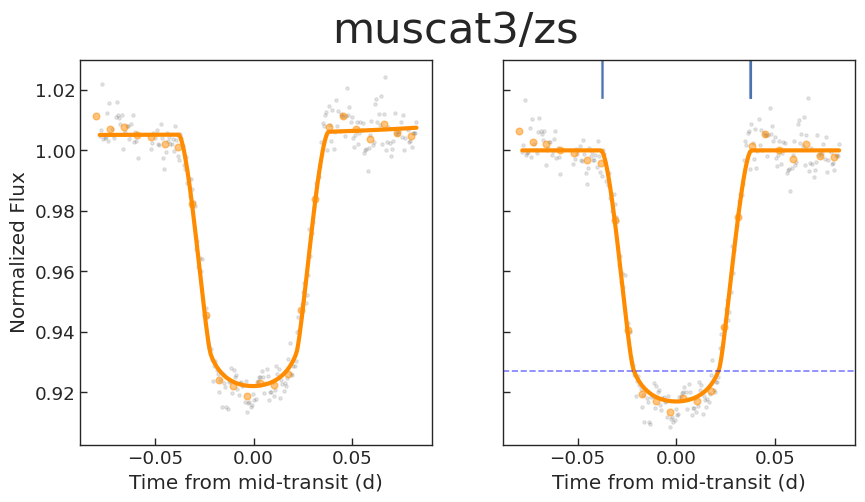

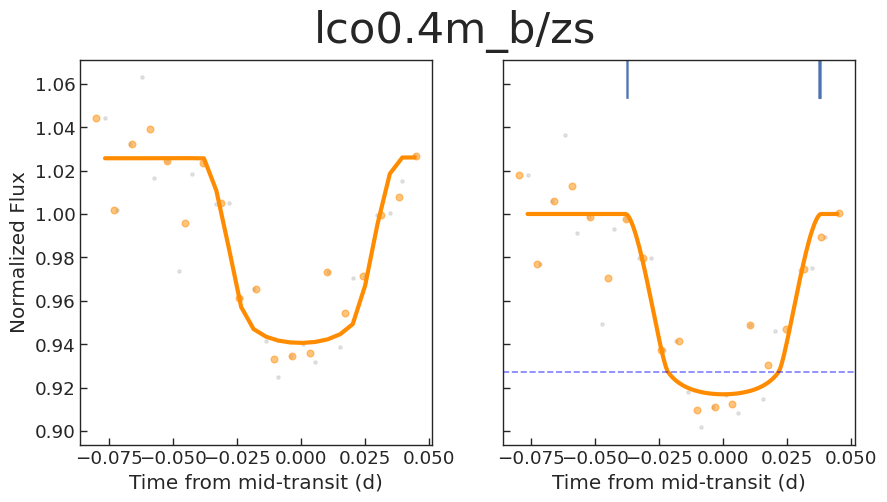

In [23]:
# using optimized parameters
pv = tf.optimum_params
# pv = [v[0] for k,v in tf.model_params.items()]
fig = tf.plot_lightcurves(pv, figsize=(10,5))

In [24]:
pv = tf.pv_init
# tf.optimum_params = pv
tf.sample_mcmc(pv, nsteps=1000)

100%|███████████████████████████████████████| 1000/1000 [03:02<00:00,  5.49it/s]


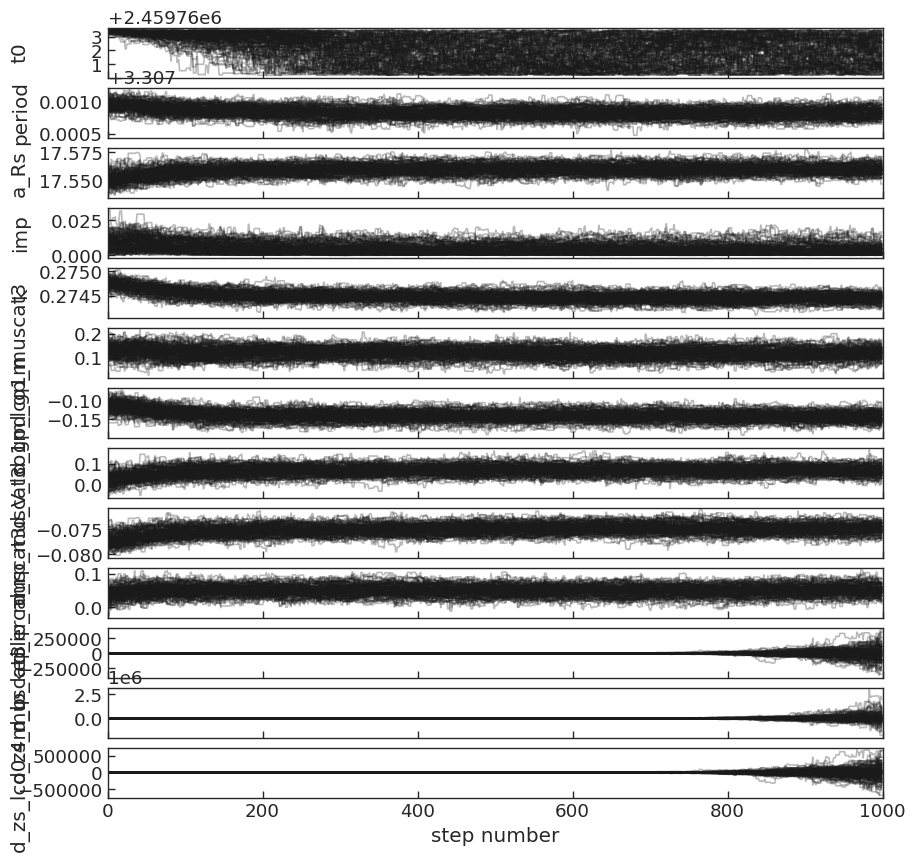

In [25]:
fig = tf.plot_chain()

In [26]:
df = tf.get_mcmc_samples(discard=500)
df.head()

,t0,period,a_Rs,imp,k,d_gp_muscat3,d_gp_lco1m,d_V_lco1m,d_rp_muscat3,d_ip_muscat3,d_ip_keplercam,d_zs_muscat3,d_zs_lco0.4m_b
0,2.459762e+06,3.307785,17.566148,0.005406,0.274507,0.112136,-0.145725,0.105516,-0.075986,0.061161,-72.292696,-142.487403,-109.064906
1,2.459762e+06,3.307780,17.560528,0.010962,0.274420,0.108103,-0.142629,0.074011,-0.073117,0.047344,0.129396,-883.377384,-94.869539
2,2.459760e+06,3.307861,17.557268,0.002089,0.274479,0.096679,-0.158189,0.112837,-0.075140,0.026168,75.635933,-180.503400,104.215293
3,2.459763e+06,3.307940,17.570778,0.009683,0.274308,0.156642,-0.136141,0.083972,-0.073263,0.029093,214.542782,-997.253458,269.893102
4,2.459763e+06,3.307930,17.560311,0.007177,0.274528,0.107233,-0.134258,0.062852,-0.076271,0.042414,-43.312512,-7.262943,-56.731916


In [27]:
outdir = './joint'
if True:
    outfile = f'{outdir}/{tf.model}_samples.csv.gz'
    df.to_csv(outfile, index=False)
    print("Saved: ", outfile)

Saved:  ./joint/achromatic_samples.csv.gz


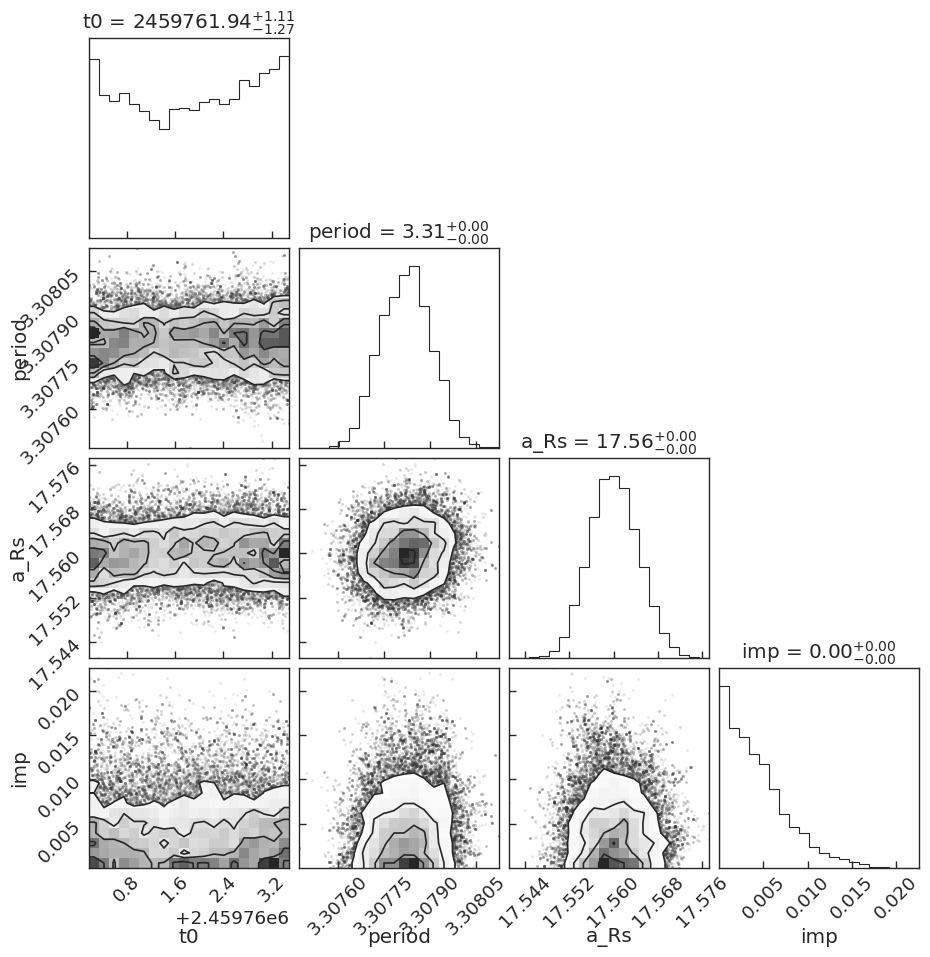

In [28]:
fig = tf.plot_corner(start=0, end=4, discard=500, transform=False)

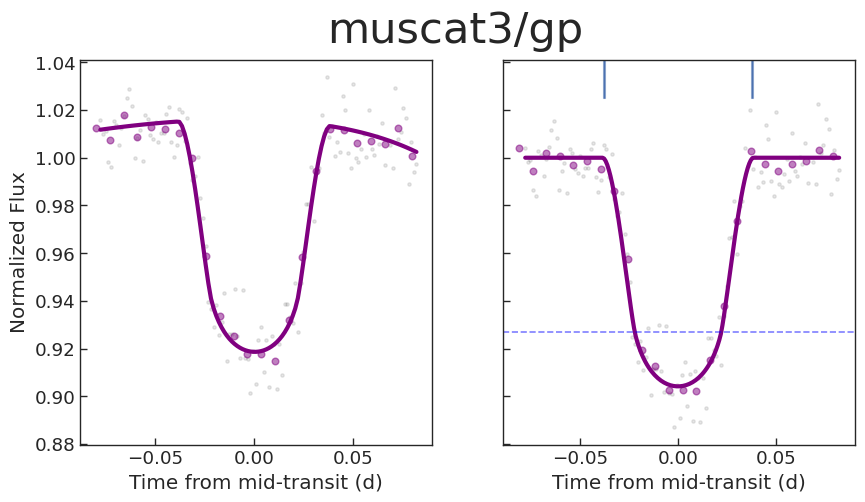

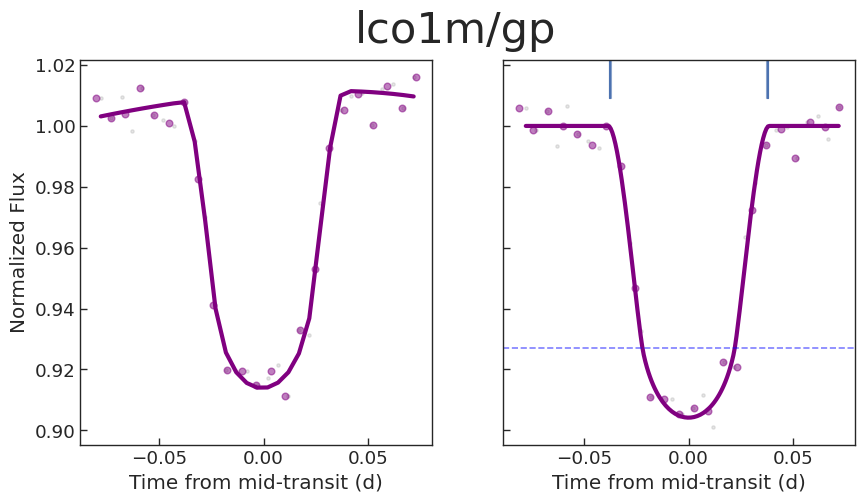

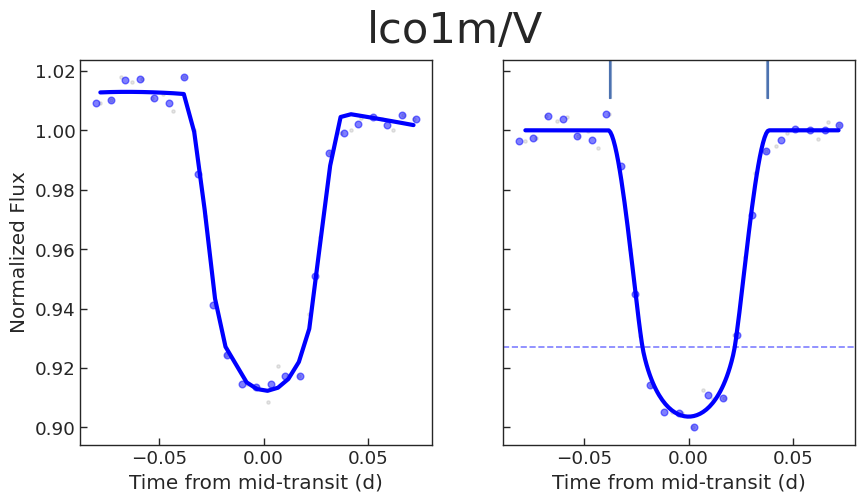

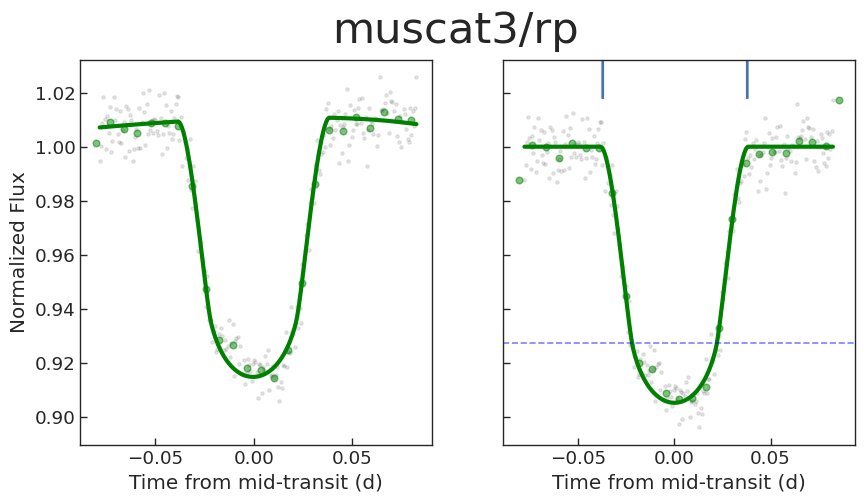

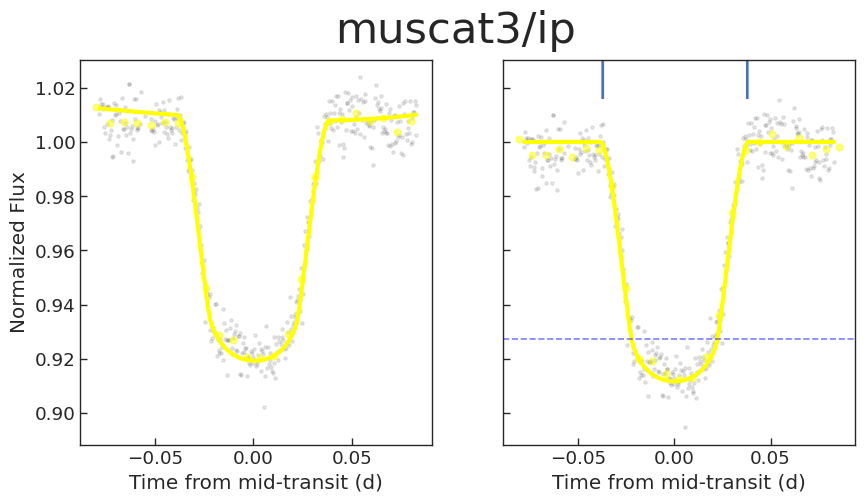

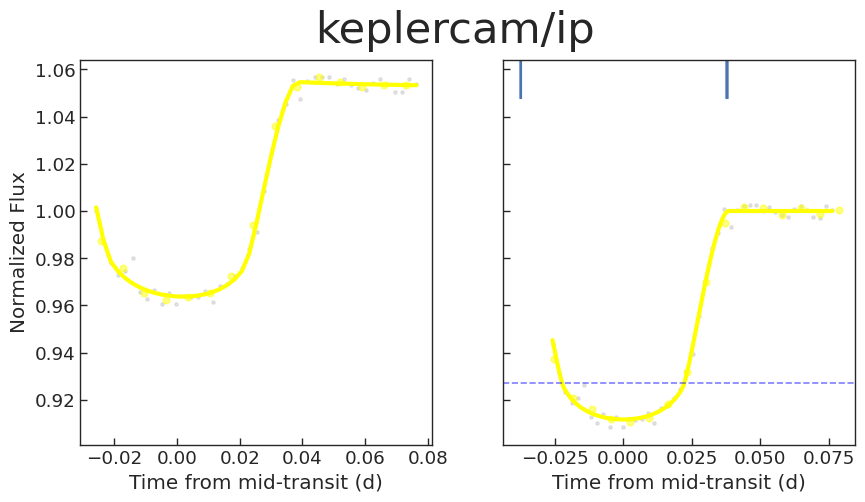

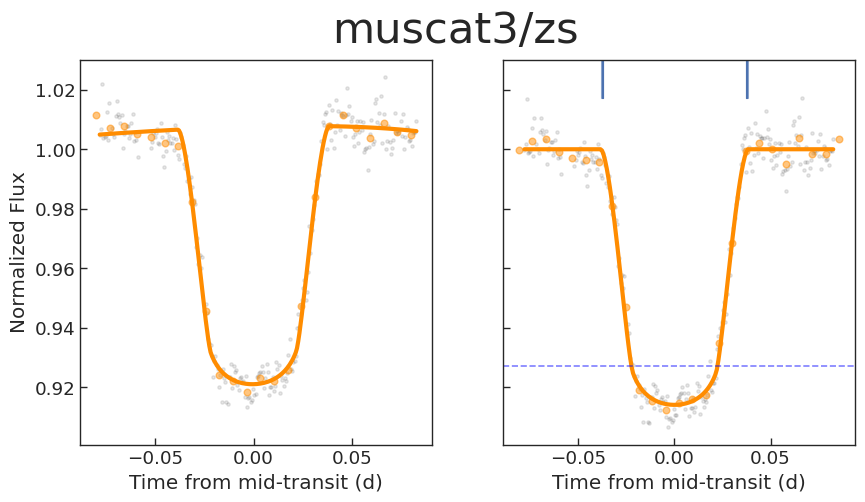

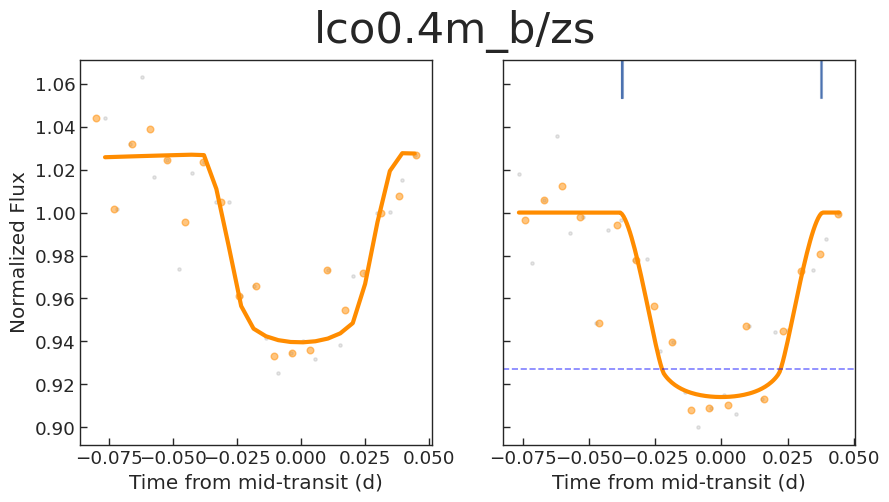

In [31]:
pv = tf.best_fit_params
fig = tf.plot_lightcurves(pv, figsize=(10,5))

In [62]:
from toi5671 import binning_equal_interval, AutoMinorLocator

def plot_final_fit(
    self,
    discard: int = 1,
    thin: int = 1,
    nsamples: int = 100,
    ylims_top: tuple = (0.9, 1.02),
    ylims_bottom: tuple = (0.9, 1.02),
    msize: int = 5,
    font_size: int = 25,
    title: str = None,
    figsize: tuple = (16, 12),
    binsize: float = 600 / 86400
):
    ymin1, ymax1 = ylims_top
    ymin2, ymax2 = ylims_bottom

    fig, ax = pl.subplots(
        2, self.ndatasets, figsize=figsize, sharey="row", sharex="col"
    )
    pl.subplots_adjust(hspace=0.1, wspace=0)
    
    # unpack free parameters
    if not hasattr(self, "best_fit_params"):
        raise ValueError("Run `sample_mcmc()` first.")

    pv = self.best_fit_params
    if self.use_r1r2:
        t0_best, per_best, a_Rs_best, r1, r2, d_best = self.unpack_parameters(pv)
        imp_best, k_best = r1r2_to_imp_k(
            r1, r2, k_lo=PRIOR_K_MIN, k_up=PRIOR_K_MAX
        )
    else:
        t0_best, per_best, a_Rs_best, imp_best, k_best, d_best = self.unpack_parameters(pv)

    # derived
    inc_best = np.arccos(imp_best / a_Rs_best)

    trends_best = self.get_trend_models(self.best_fit_params)
    transits_best = self.get_upsampled_transit_models(self.best_fit_params)

    # fc = self.sampler.get_chain(flat=True, discard=discard, thin=thin)
    fc = self.sampler.flatchain.copy()
    if discard > 1:
        fc = fc.reshape(self.nsteps, self.nwalkers, -1)
        fc = fc[discard::thin].reshape(-1, self.ndim)
    i = 0
    for n,(b,dfs) in enumerate(self.data.items()):
        for inst, df in dfs.items():
            t = self.times[b][inst]
            f = self.fluxes[b][inst]
            e = self.flux_errs[b][inst]
            z = self.covariates[b][inst]
            tc = get_epoch_tc(t, per_best, t0_best)
            dt = t-int(tc)
            # raw and binned data
            tbin, ybin, yebin = binning_equal_interval(dt, f, e, binsize, tc)
            ax[0, i].plot(dt, f, ".k", alpha=0.1)
            ax[0, i].errorbar(tbin, ybin, yerr=yebin, fmt="ok", markersize=msize)

            # plot each random mcmc samples
            rand = np.random.randint(len(fc), size=nsamples)
            for j in range(len(rand)):
                idx = rand[j]
                # unpack free parameters
                if self.use_r1r2:
                    tc, per, a_Rs, r1 = fc[idx, : self.k_idx]
                    if self.model == "chromatic":
                        r2 = fc[idx, self.k_idx : self.d_idx]
                    elif self.model == "achromatic":
                        r2 = np.zeros(self.nband) + fc[idx, self.k_idx]
                    imp, k = r1r2_to_imp_k(
                        r1, r2, k_lo=PRIOR_K_MIN, k_up=PRIOR_K_MAX
                    )
                else:
                    t0, per, a_Rs, imp = fc[idx, : self.k_idx]
                    if self.model == "chromatic":
                        k = fc[idx, self.k_idx : self.d_idx]
                    elif self.model == "achromatic":
                        k = np.zeros(self.nband) + fc[idx, self.k_idx]
                d = fc[idx, self.d_idx : self.d_idx + self.nband]
                # derived parameters
                inc = np.arccos(imp / a_Rs)
                # transit
                flux_tr = self.transit_models[b][inst].evaluate_ps(
                    k[n], self.ldc[b], tc, per, a_Rs, inc, e=0, w=0
                )
                flux_tr_time = d[i] * (t - tc) * flux_tr
                c = np.polyfit(z, (f - flux_tr_time) / flux_tr, self.lm_order)
                # transit with trend
                ax[0, i].plot(
                    dt,
                    flux_tr * (np.polyval(c, z) + d[i] * (t - tc)),
                    alpha=0.05,
                    color=colors[b],
                )

            # best-fit transit model
            flux_tr = self.transit_models[b][inst].evaluate_ps(
                k_best[i],
                self.ldc[b],
                t0_best,
                per_best,
                a_Rs_best,
                inc_best,
                e=0,
                w=0,
            )

            tbin, ybin, yebin = binning_equal_interval(
                dt, f / trends_best[b][inst], e, binsize, t0
            )
            # detrended flux
            ax[1, i].plot(dt, f / trends_best[b][inst], ".k", alpha=0.1)
            ax[1, i].errorbar(tbin, ybin, yerr=yebin, fmt="ok", markersize=msize)
            # super sampled best-fit transit model
            xmodel, ymodel = transits_best[b][inst]
            ax[1, i].plot(xmodel-int(tc), ymodel, color=colors[b], linewidth=3)
            ax[0, i].yaxis.set_minor_locator(AutoMinorLocator(5))
            ax[1, i].yaxis.set_minor_locator(AutoMinorLocator(5))
            ax[0, i].xaxis.set_minor_locator(AutoMinorLocator(5))
            ax[1, i].xaxis.set_minor_locator(AutoMinorLocator(5))
            ax[0, i].set_ylim(ymin1, ymax1)
            ax[1, i].set_ylim(ymin2, ymax2)

            tx = np.min(dt) + (np.max(dt) - np.min(dt)) * 0.75
            ty = ymin1 + (ymax1 - ymin1) * 0.9
            ax[0, i].text(
                tx, ty, f"{inst}/{b}", color=colors[b], fontsize=font_size * 0.6
            )
            tx = np.min(dt) + (np.max(dt) - np.min(dt)) * 0.02
            ty = ymin2 + (ymax2 - ymin2) * 0.8
            ax[1, i].text(tx, ty, "Detrended", fontsize=font_size * 0.6)

            rms = np.std(
                f - flux_tr * (np.polyval(c, z) + d_best[i] * (t - tc))
            )
            rms_text = f"rms = {rms:.4f}"
            ty = ymin2 + (ymax2 - ymin2) * 0.1
            ax[1, i].text(tx, ty, rms_text, fontsize=font_size * 0.6)
            depth = self.planet_params["rprs"][0] ** 2
            ax[1, i].axhline(
                1 - depth,
                color="blue",
                linestyle="dashed",
                label="TESS",
                alpha=0.5,
            )
            _ = self.plot_ing_egr(ax=ax[1, i], ymin=0.9, ymax=1.0, color="C0")
            if i == 0:
                ax[0, i].set_ylabel("Flux ratio", fontsize=font_size)
                ax[1, i].set_ylabel("Flux ratio", fontsize=font_size)
                ax[0, i].tick_params(labelsize=16)
                ax[1, i].tick_params(labelsize=16)
                target_name = (
                    f"{self.name}{self.alias}"
                    if title is None
                    else title
                )
                ax[0, i].text(
                    0.0,
                    1.14,
                    target_name,
                    horizontalalignment="left",
                    verticalalignment="center",
                    transform=ax[0, i].transAxes,
                    fontsize=font_size,
                )
                text = f"{self.model.title()} transit fit,  "
                text += f"$\Delta$BIC (non-transit - transit) = {self.bic_delta:.1f}"
                ax[0, i].text(
                    0.0,
                    1.05,
                    text,
                    horizontalalignment="left",
                    verticalalignment="center",
                    transform=ax[0, i].transAxes,
                    fontsize=font_size * 0.6,
                )
            # if (i > 0) and (i == self.nband - 1):
            #     ax[0, i].set_title("", loc="right", fontsize=font_size * 0.8)
            if i > 0:
                ax[0, i].tick_params(
                    labelleft=False,
                    labelright=False,
                    labeltop=False,
                    labelsize=16,
                )
                ax[1, i].tick_params(
                    labelleft=False,
                    labelright=False,
                    labeltop=False,
                    labelsize=16,
                )
            ax[1, i].set_xlabel(
                f"BJD - {int(tc):.0f}",
                labelpad=30,
                fontsize=font_size,
            )
        i+=1
    ax[1, i].legend(loc="lower right", fontsize=12)
    return fig

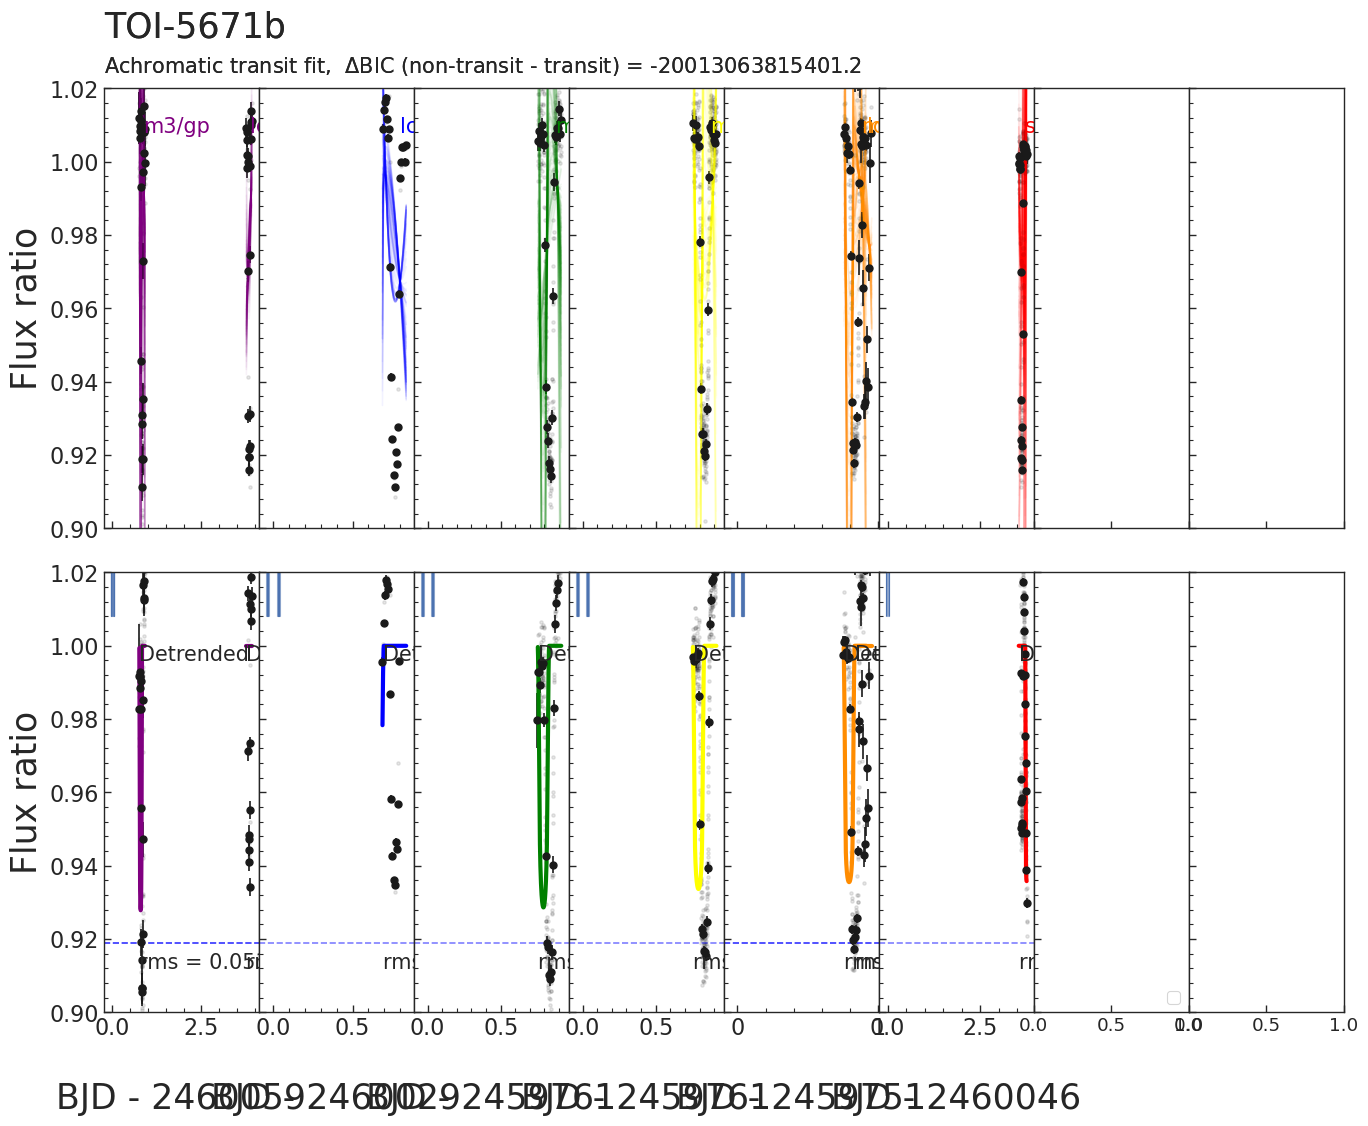

In [63]:
fig = plot_final_fit(tf)